In [18]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import pandas as pd
import numpy as np
import glob,os
from tqdm.auto import tqdm
import math
import sklearn
from sklearn.linear_model import LinearRegression

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.models import Models, Prediction
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

In [21]:
def select_links(tau_min, tau_max, parents, children):
    """
    This function selects the causal links that will be tested by
    PCMCI. The links are selected such that per each variable in
    `children` all `parents` are stablished as causes, and no other
    causal relationships exist.
    
    Assumes `parents` and `children` are disjoint sets, and that all
    variables are included in the union of both sets.
    
    Parameters
    ----------
    tau_min : int
        Minimum time lag to test. Note that zero-lags are undirected.
    tau_max : int
        Maximum time lag. Must be larger or equal to tau_min.
    parents : set of int
        List of variables that will be assigned as a parent link.
        Assumed to be disjoint with children
    children : set of int
        List of variables that will be assigned a link from a parent.
        Assumed to be disjoint with parents
    Returns
    -------
    selected_links: dict
        Dictionary of selected links for Tigramite
        
    """

    parents = set(parents)
    children = set(children)

    selected_links = dict()
    # Set the default as all combinations of the selected variables
    for var in [*children, *parents]:
        if var in children:
            # Children can be caused only by parents and by themselves
            selected_links[var] = [
                (parent, -lag)
                for parent in parents
                for lag in range(tau_min, tau_max + 1)
            ]
        else:
            selected_links[var] = []

    return selected_links

def _process_dataset(path=None):
    df1 = pd.read_csv(path,sep=',')
    df1.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
    df1=df1.drop('a', axis=1)
    df1=df1.drop('conv_rrate', axis=1)
    df1=df1.drop('ls_rrate', axis=1)
    df1=df1.drop('mn_conv_prate', axis=1)
    df1=df1.drop('mn_ls_prate', axis=1)
    df1=df1.drop('mn_tot_prate', axis=1)
    df1=df1.drop('outconv_rrate', axis=1)
    df1=df1.drop('outls_rrate', axis=1)
    df1=df1.drop('outmn_conv_prate', axis=1)
    df1=df1.drop('outmn_ls_prate', axis=1)
    df1=df1.drop('outmn_tot_prate', axis=1)
    df1=df1.drop('conv_ppt', axis=1)
    df1=df1.drop('outconv_ppt', axis=1)
    
    TCname = path.split('/')[-1].split('.')[0].split('_')[-1]
    #print(TCname)
    for item in glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/targets/*tot_ppt_int*'):
        if str(TCname) in item:
            #print(item)
            d1=pd.read_csv(item)
            d1.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
            d1=d1.drop('a', axis=1)
            dt1=pd.concat([d1,df1],axis=1, join='inner')
        else:
            continue
    return dt1

In [22]:
p1="../../tigramite_timeseries/"
p2="../../targets/"

In [23]:
!ls /work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/targets/

2001_pmin_nio_as1.csv			 2015_w10max_nwp_mujigae.csv
2001_pmin_nio_as2.csv			 2016_integrated_prate_nio_kyant.csv
2001_tot_ppt_int_nio_may2001.csv	 2016_integrated_prate_nio_roanu.csv
2001_tot_ppt_int_nio_oct2001.csv	 2016_integrated_prate_nio_vardah.csv
2001_tot_ppt_max_nio_as1.csv		 2016_integrated_prate_nwp_haimaa.csv
2001_tot_ppt_max_nio_as2.csv		 2016_integrated_prate_nwp_haima.csv
2002_pmin_nio_as1.csv			 2016_integrated_prate_nwp_megi.csv
2002_pmin_nio_bob1.csv			 2016_integrated_prate_nwp_sarika.csv
2002_tot_ppt_int_nio_may2002.csv	 2016_pmin_nio_kyant.csv
2002_tot_ppt_int_nio_nov2002.csv	 2016_pmin_nio_roanu.csv
2002_tot_ppt_max_nio_as1.csv		 2016_pmin_nio_vardah.csv
2002_tot_ppt_max_nio_bob1.csv		 2016_pmin_nwp_haimaa.csv
2003_pmin_nio_as1.csv			 2016_pmin_nwp_haima.csv
2003_pmin_nio_bob1.csv			 2016_pmin_nwp_megi.csv
2003_pmin_nio_bob2.csv			 2016_pmin_nwp_sarika.csv
2003_tot_ppt_int_nio_asnov2003.csv	 2016_pratemax_nio_kyant.csv
2003_tot_ppt_int_nio_dec2003.csv	 2016_pratem

In [24]:
ds1=_process_dataset(glob.glob(p1+'*vongfong*')[0])
ds2=_process_dataset(glob.glob(p1+'*chanhom*')[0])
ds3=_process_dataset(glob.glob(p1+'*saudel*')[0])
ds4=_process_dataset(glob.glob(p1+'*molave*')[0])
ds5=_process_dataset(glob.glob(p1+'*goni*')[0])
ds6=_process_dataset(glob.glob(p1+'*atsani*')[0])
ds7=_process_dataset(glob.glob(p1+'*vamco*')[0])
ds8=_process_dataset(glob.glob(p1+'*neoguri*')[0])
ds9=_process_dataset(glob.glob(p1+'*bualoi*')[0])
ds10=_process_dataset(glob.glob(p1+'*halong*')[0])
ds11=_process_dataset(glob.glob(p1+'*nakri*')[0])
ds12=_process_dataset(glob.glob(p1+'*fengshen*')[0])
ds13=_process_dataset(glob.glob(p1+'*kalmaegi*')[0])
ds14=_process_dataset(glob.glob(p1+'*fungwong*')[0])
ds15=_process_dataset(glob.glob(p1+'*kammuri*')[0])
ds16=_process_dataset(glob.glob(p1+'*jelawat*')[0])
ds17=_process_dataset(glob.glob(p1+'*maliksi*')[0])
ds18=_process_dataset(glob.glob(p1+'*kongrey*')[0])
ds19=_process_dataset(glob.glob(p1+'*yutu*')[0])
ds20=_process_dataset(glob.glob(p1+'*muifa*')[0])
ds21=_process_dataset(glob.glob(p1+'*lan*')[0])
ds22=_process_dataset(glob.glob(p1+'*damrey*')[0])
ds23=_process_dataset(glob.glob(p1+'*haikul*')[0])
ds24=_process_dataset(glob.glob(p1+'*megi*')[0])
ds25=_process_dataset(glob.glob(p1+'*sarika*')[0])
ds26=_process_dataset(glob.glob(p1+'*haimaa*')[0])
ds27=_process_dataset(glob.glob(p1+'*maysak*')[0])
ds28=_process_dataset(glob.glob(p1+'*mujigae*')[0])
ds29=_process_dataset(glob.glob(p1+'*koppu*')[0])
ds30=_process_dataset(glob.glob(p1+'*infa*')[0])
ds31=_process_dataset(glob.glob(p1+'*tapah*')[0])
ds32=_process_dataset(glob.glob(p1+'*nuri*')[0])
ds33=_process_dataset(glob.glob(p1+'*hagupit*')[0])
ds34=_process_dataset(glob.glob(p1+'*yagi*')[0])
ds35=_process_dataset(glob.glob(p1+'*fitow*')[0])
ds36=_process_dataset(glob.glob(p1+'*danas*')[0])
ds37=_process_dataset(glob.glob(p1+'*francisco*')[0])
ds38=_process_dataset(glob.glob(p1+'*krosa*')[0])
ds39=_process_dataset(glob.glob(p1+'*haiyan*')[0])
ds40=_process_dataset(glob.glob(p1+'*guchol*')[0])
ds41=_process_dataset(glob.glob(p1+'*gaemi*')[0])
ds42=_process_dataset(glob.glob(p1+'*maria*')[0])
ds43=_process_dataset(glob.glob(p1+'*sontinh*')[0])
ds44=_process_dataset(glob.glob(p1+'*bopha*')[0])
ds45=_process_dataset(glob.glob(p1+'*songda*')[0])
ds46=_process_dataset(glob.glob(p1+'*haima*')[0])
ds47=_process_dataset(glob.glob(p1+'*nalgae*')[0])
ds48=_process_dataset(glob.glob(p1+'*washi*')[0])

In [25]:
tcwp1=ds1.values
tcwp2=ds2.values
tcwp3=ds3.values
tcwp4=ds4.values
tcwp5=ds5.values
tcwp6=ds6.values
tcwp7=ds7.values
tcwp8=ds8.values
tcwp9=ds9.values
tcwp10=ds10.values
tcwp11=ds11.values
tcwp12=ds12.values
tcwp13=ds13.values
tcwp14=ds14.values
tcwp15=ds15.values
tcwp16=ds16.values
tcwp17=ds17.values
tcwp18=ds18.values
tcwp19=ds19.values
tcwp20=ds20.values
tcwp21=ds21.values
tcwp22=ds22.values
tcwp23=ds23.values
tcwp24=ds24.values
tcwp25=ds25.values
tcwp26=ds26.values
tcwp27=ds27.values
tcwp28=ds28.values
tcwp29=ds29.values
tcwp30=ds30.values
tcwp31=ds31.values
tcwp32=ds32.values
tcwp33=ds33.values
tcwp34=ds34.values
tcwp35=ds35.values
tcwp36=ds36.values
tcwp37=ds37.values
tcwp38=ds38.values
tcwp39=ds39.values
tcwp40=ds40.values
tcwp41=ds41.values
tcwp42=ds42.values
tcwp43=ds43.values
tcwp44=ds44.values
tcwp45=ds45.values
tcwp46=ds46.values
tcwp47=ds47.values
tcwp48=ds48.values

West Pacific Storms

In [26]:
ddwp={'cyclone1':tcwp1,'cyclone2':tcwp2,'cyclone3':tcwp3,'cyclone4':tcwp4,'cyclone5':tcwp5,'cyclone6':tcwp6,
      'cyclone7':tcwp7, 'cyclone8':tcwp8,'cyclone9':tcwp9,'cyclone10':tcwp10,'cyclone11':tcwp11,'cyclone12':tcwp12,
      'cyclone13':tcwp13,'cyclone14':tcwp14,'cyclone15':tcwp15,'cyclone16':tcwp16,'cyclone17':tcwp17,'cyclone18':tcwp18,
      'cyclone19':tcwp19,'cyclone20':tcwp20,'cyclone21':tcwp21,'cyclone22':tcwp22,'cyclone23':tcwp23,'cyclone24':tcwp24,
      'cyclone25':tcwp25,'cyclone26':tcwp26,'cyclone27':tcwp27,'cyclone28':tcwp28,'cyclone29':tcwp29,'cyclone30':tcwp30,
      'cyclone31':tcwp31,'cyclone32':tcwp32,'cyclone33':tcwp33,'cyclone34':tcwp34,'cyclone35':tcwp35,'cyclone36':tcwp36,
      'cyclone37':tcwp37,'cyclone38':tcwp38,'cyclone39':tcwp39,'cyclone40':tcwp40,'cyclone41':tcwp41,'cyclone42':tcwp42,
      'cyclone43':tcwp43,'cyclone44':tcwp44,'cyclone45':tcwp45,'cyclone46':tcwp46,'cyclone47':tcwp47,'cyclone48':tcwp48}

In [27]:
class Pipeline:
    """
    Tigramite and Linear Regression Pipeline
    """
    def __init__(self,data,pc_alpha,alpha_level,pc_type='run_pcstable' or 'pcmci',tau_min0=None,tau_max0=None,
                 target='precip',var_name=None,seed=None,cond_ind_test=ParCorr()):
        self.pc_alpha = pc_alpha
        self.alpha_level = alpha_level
        self.data = data
        self.pc_type = pc_type
        self.target = target
        self.tau_min0 = tau_min0
        self.tau_max0 = tau_max0
        self.var_name = var_name
        self.seed = seed
        self.cond_ind_test = cond_ind_test
        
    #################################################################################
    # Step 0: Split
    #################################################################################
    def splitdata(self,testindex=None):
        datae = self.data.copy()
        traindata = {}
        testdata = {}
        validdata = {}
        validindex,newtestindex = testindex[:int(len(testindex)/2)],testindex[int(len(testindex)/2):]
        for obj in datae.keys():
            number = int(obj[7:])
            if number in list(newtestindex):
                testdata['cyclone'+str(number)] = datae['cyclone'+str(number)]
            elif number in list(validindex):
                validdata['cyclone'+str(number)] = datae['cyclone'+str(number)]
            else:
                traindata['cyclone'+str(number)] = datae['cyclone'+str(number)]
        return traindata,validdata,testdata
    
    #################################################################################
    # Step 1: Tigramite
    #################################################################################
    def run_tigramite(self,lengthtrain=None):
        #assert len(self.data)==lengthtrain,"Wrong shape!"
        datae = self.data.copy()
        dataframe =  pp.DataFrame(datae,analysis_mode ='multiple', var_names=var_names)
        #################################################################################
        # Sel links
        #################################################################################
        for member in dataframe.values.keys():
            children = [0,1,2]
            parents = np.arange(3,259)
            sel_links = select_links(self.tau_min0, self.tau_max0, parents, children)
        #################################################################################
        # Run Tigramite
        #################################################################################        
        pcmci = PCMCI(dataframe = dataframe, cond_ind_test = self.cond_ind_test)
        if self.pc_type=='run_pcstable':
            results = pcmci.run_pc_stable(selected_links=sel_links, tau_min=self.tau_min0, tau_max=self.tau_max0,\
                                          pc_alpha=self.pc_alpha)
        elif self.pc_type=='pcmci':
            results = pcmci.run_pcmci(selected_links=sel_links, tau_min=self.tau_min0, tau_max=self.tau_max0,\
                                      pc_alpha=self.pc_alpha)

        pcmci.verbosity = 2
        #################################################################################
        # Test
        #################################################################################   
        #pcmci.print_results(results,self.alpha_level)
        #pcmci.print_significant_links(p_matrix=results['p_matrix'],
        #val_matrix = results['val_matrix'],
        #alpha_level = self.alpha_level)
        return results
    
    #################################################################################
    # Step 2: Linear Regression
    #################################################################################
    # Helper functions
    #################################################################################
    def random_testindex(self,totalexp=None,testexp=None):
        from numpy.random import default_rng
        rng = default_rng(self.seed)
        seed = rng.choice(totalexp, testexp, replace=False)
        return seed
    
    def extract_lag_info(self,datar=None,varindex=None,lag=None):
        temp = datar[:,varindex] # Full time series
        store = []
        for timeindex in range(len(temp)):
            if timeindex < np.abs(lag):
                store.append(np.nan)
            elif timeindex > len(temp)-1-np.abs(lag):
                store.append(np.nan)
            else:
                store.append(temp[timeindex-np.abs(lag)])
        return store
    
    def extract_var_and_lag(self,pcmci_results=None,p_or_q='p' or 'q'):
        datae = self.data.copy()
        dataframe =  pp.DataFrame(datae,analysis_mode ='multiple', var_names=var_names)
        pcmci = PCMCI(dataframe = dataframe, cond_ind_test = self.cond_ind_test)
        #################################################################################
        # Sel links
        #################################################################################
        for member in dataframe.values.keys():
            children = [0,1,2]
            parents = np.arange(3,259)
            sel_links = select_links(self.tau_min0, self.tau_max0, parents, children)
        
        q_matrix = pcmci.get_corrected_pvalues(p_matrix=pcmci_results['p_matrix'],
                                               selected_links = sel_links, 
                                               tau_min=self.tau_min0,tau_max=self.tau_max0, fdr_method='fdr_bh')
        #################################################################################
        # Save vars and lags
        #################################################################################
        if p_or_q=='p':
            sig_links = (pcmci_results['p_matrix'].copy() <= self.alpha_level)
        elif p_or_q=='q':
            sig_links = (q_matrix.copy() <= self.alpha_level)
        arr = []
        for j in range(3):
            links = {(p[0], -p[1]): np.abs(pcmci_results['val_matrix'][p[0],j,abs(p[1])]) for p in zip(*np.where(sig_links[:,j,:]))}
            # Sort by value
            sorted_links = sorted(links, key=links.get, reverse=True)
            arr.append(sorted_links)
        return arr
    
    def extract_var_and_lag_stable(self,pcmci_results=None,p_or_q='p' or 'q'):
        datae = self.data.copy()
        dataframe =  pp.DataFrame(datae,analysis_mode ='multiple', var_names=var_names)
        pcmci = PCMCI(dataframe = dataframe, cond_ind_test = self.cond_ind_test)
        #################################################################################
        # Sel links
        #################################################################################
        for member in dataframe.values.keys():
            children = [0,1,2]
            parents = np.arange(3,259)
            sel_links = select_links(self.tau_min0, self.tau_max0, parents, children)
        
        q_matrix = pcmci.get_corrected_pvalues(p_matrix=pcmci_results['p_matrix'],
                                               selected_links = sel_links, 
                                               tau_min=self.tau_min0,tau_max=self.tau_max0, fdr_method='fdr_bh')
        #################################################################################
        # Save vars and lags
        #################################################################################
        if p_or_q=='p':
            sig_links = (pcmci_results['p_matrix'].copy() <= self.alpha_level)
        elif p_or_q=='q':
            sig_links = (q_matrix.copy() <= self.alpha_level)
        arr = []
        for j in range(3):
            links = {(p[0], -p[1]): np.abs(pcmci_results['val_matrix'][p[0],j,abs(p[1])]) for p in zip(*np.where(sig_links[:,j,:]))}
            # Sort by value
            sorted_links = sorted(links, key=links.get, reverse=True)
            arr.append(sorted_links)
        return arr
    
    #################################################################################
    # Process functions
    #################################################################################
    def preproc_ts_withnan(self,links=None,group=None,trainmean=None,trainstd=None):
        if self.target=='precip':
            arrtarget,ytarget = links[0],[self.data[obj][:,0] for obj in self.data.keys()]
        elif self.target=='pmin':
            arrtarget,ytarget = links[1],[self.data[obj][:,1] for obj in self.data.keys()]
        elif self.target=='v10':
            arrtarget,ytarget = links[2],[self.data[obj][:,2] for obj in self.data.keys()]
        
        # 1. Extract time series with nan
        varindexstore,lagstore,TS_store,flatTS_store = [],[],[],[]
        for varindex,lag in arrtarget:
            varindexstore.append(varindex)
            lagstore.append(lag)
            tempp = [self.extract_lag_info(datar=self.data[obj],varindex=varindex,lag=lag) for obj in self.data.keys()]
            TS_store.append(tempp)
            flatTS_store.append(np.concatenate([obj for obj in tempp]))
        
        # 2. Normalize
        if group=='train':
            TSnorml_store,meanstore,stdstore = [],[],[]
            for i in range(len(TS_store)):
                tempmean,tempstd = np.nanmean(flatTS_store[i]),np.nanstd(flatTS_store[i])
                TSnorml_store.append([(obj-tempmean)/tempstd for obj in TS_store[i]])
                meanstore.append(tempmean)
                stdstore.append(tempstd)
        elif (group=='test') or (group=='valid'):
            TSnorml_store = []
            for i in range(len(TS_store)):
                tempmean,tempstd = (trainmean[i]),(trainstd[i])
                TSnorml_store.append([(obj-tempmean)/tempstd for obj in TS_store[i]])
            
        # 3. Concatenate
        #validindex,testindex = validtestindex[0:int(np.round(len(validtestindex)/2))],\
        #validtestindex[int(np.round(len(validtestindex)/2)):]
        
        Xtrain_withnan_store = []
        for i in range(len(TS_store)):
            storelist = [i for j, i in enumerate(TSnorml_store[i])]
            Xtrain_withnan_store.append(np.concatenate([obj for obj in storelist]))
            
        Ytrain = np.concatenate([i for j, i in enumerate(ytarget)])
        if group=='train':
            return Xtrain_withnan_store,Ytrain,meanstore,stdstore
        elif group=='valid':
            return Xtrain_withnan_store,Ytrain
        elif group=='test':
            return Xtrain_withnan_store,Ytrain
    
    def remove_nan(self,Xdict=None,ydict=None):
        def _remove_nan(X=None,y=None):
            X_nonan,Y_nonan = [],[]
            X_withnan_storer = np.asarray(X).transpose()
            for i in (range(len(y))):
                tempX = X_withnan_storer[i,:]
                if np.isnan(tempX).any():
                    continue
                else:
                    X_nonan.append(tempX)
                    Y_nonan.append(y[i])
            return X_nonan,Y_nonan
        Xtrain,ytrain = _remove_nan(X=Xdict['train'],y=ydict['train'])
        Xvalid,yvalid = _remove_nan(X=Xdict['valid'],y=ydict['valid'])
        Xtest,ytest = _remove_nan(X=Xdict['test'],y=ydict['test'])
        return {'train':Xtrain,'valid':Xvalid,'test':Xtest},{'train':ytrain,'valid':yvalid,'test':ytest}

    #################################################################################
    # Train model
    #################################################################################
    def train_mlr(self,X=None,y=None):
        regr = LinearRegression()
        regr.fit(X['train'],y['train'])
        return regr

In [28]:
def trainMLR_target(target='precip' or 'pmin' or 'v10',seed=12345):
    ################################################################################################################
    # 1. X,y with nan
    Xtrain_nan,ytrain_nan,trainmean,trainstd = Pipeline(traindata,pc_alpha,alpha_level,pc_type='pcmci',\
                                                        tau_min0=1,tau_max0=16,\
                                                        target=target,var_name=var_names,\
                                                        seed=seed).preproc_ts_withnan(links=var_and_lag,group='train',\
                                                                                       trainmean=None,trainstd=None)
    Xvalid_nan,yvalid_nan = Pipeline(validdata,pc_alpha,alpha_level,pc_type='pcmci',\
                                   tau_min0=1,tau_max0=16,target=target,\
                                   var_name=var_names,seed=seed).preproc_ts_withnan(links=var_and_lag,\
                                                                                     group='valid',\
                                                                                     trainmean=trainmean,\
                                                                                     trainstd=trainstd)
    
    Xtest_nan,ytest_nan = Pipeline(testdata,pc_alpha,alpha_level,pc_type='pcmci',\
                                   tau_min0=1,tau_max0=16,target=target,\
                                   var_name=var_names,seed=seed).preproc_ts_withnan(links=var_and_lag,\
                                                                                     group='test',\
                                                                                     trainmean=trainmean,\
                                                                                     trainstd=trainstd)
    X_nan = {'train':Xtrain_nan,'valid':Xvalid_nan,'test':Xtest_nan}
    y_nan = {'train':ytrain_nan,'valid':yvalid_nan,'test':ytest_nan}
    ################################################################################################################
    # 2. remove nan
    X_nonan,y_nonan = Pipeline(traindata,pc_alpha,alpha_level,pc_type='pcmci',\
                               tau_min0=1,tau_max0=16,target=target,\
                               var_name=var_names,seed=seed).remove_nan(Xdict=X_nan,ydict=y_nan)
    ################################################################################################################
    # 3. Train MLR
    wpac_mlr = Pipeline(traindata,pc_alpha,alpha_level,pc_type='pcmci',\
                        tau_min0=1,tau_max0=16,target=target,\
                        var_name=var_names,seed=seed).train_mlr(X=X_nonan,y=y_nonan)
    ################################################################################################################
    return wpac_mlr,X_nonan,y_nonan

import pickle
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

In [29]:
[3e-1/2,1e-1/2,1e-2/2,1e-3/2,1e-4/2,1e-5/2,1e-6/2,1e-7/2,1e-8/2,1e-9/2]

[0.15, 0.05, 0.005, 0.0005, 5e-05, 5e-06, 5e-07, 5e-08, 5e-09, 5e-10]

#### PCSTABLE

In [17]:
result

{0: [(154, -1), (123, -1), (256, -8), (16, -3)],
 1: [(112, -1),
  (130, -1),
  (23, -1),
  (234, -1),
  (102, -3),
  (26, -1),
  (140, -6)],
 2: [(23, -1), (129, -1), (101, -1), (65, -1), (62, -1), (130, -4)],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 91:

In [32]:
pc_alphaa,alpha_level,splitsize,seednum=0.01,0.01,16,12348
pc_type = 'run_pcstable'
var_names=ds1.columns.values.tolist()
for pc_alpha in tqdm([0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01,1e-3,1e-4]):
    testindex = (Pipeline(ddwp,pc_alpha,alpha_level,pc_type=pc_type,tau_min0=1,tau_max0=16,\
                          target=None,var_name=var_names,seed=seednum).random_testindex(48,splitsize))
    traindata,validdata,testdata = Pipeline(ddwp,pc_alpha,alpha_level,pc_type=pc_type,tau_min0=1,tau_max0=16,\
                                            target='precip',var_name=var_names,seed=seednum).splitdata(testindex)
    result = Pipeline(traindata,pc_alpha,alpha_level,pc_type=pc_type,tau_min0=1,tau_max0=16,\
                      target='precip',var_name=var_names,seed=seednum).run_tigramite(int(48-splitsize))
    var_and_lag = [result[0],result[1],result[2]]
    #var_and_lag = Pipeline(traindata,pc_alpha,alpha_level,pc_type=pc_type,tau_min0=1,tau_max0=16,\
    #                       target='precip',var_name=var_names,seed=seednum).extract_var_and_lag(result,p_or_q='p')
    wpac_mlr_precip,X_precip,y_precip = trainMLR_target(target='precip',seed=seednum)
    wpac_mlr_pmin,X_pmin,y_pmin = trainMLR_target(target='pmin',seed=seednum)
    wpac_mlr_v10,X_v10,y_v10 = trainMLR_target(target='v10',seed=seednum)
    save_to_pickle(loc='./pickleddata4_pcstable/'+str(seednum)+'/causalwpac_precip.obj.'+\
                   str(pc_alpha)+'.'+str(alpha_level)+'.'+str(seednum),\
                   var={'mlr':wpac_mlr_precip,'X':X_precip,'y':y_precip})
    save_to_pickle(loc='./pickleddata4_pcstable/'+str(seednum)+'/causalwpac_pmin.obj.'+\
                   str(pc_alpha)+'.'+str(alpha_level)+'.'+str(seednum),\
                   var={'mlr':wpac_mlr_pmin,'X':X_pmin,'y':y_pmin})
    save_to_pickle(loc='./pickleddata4_pcstable/'+str(seednum)+'/causalwpac_v10.obj.'+\
                   str(pc_alpha)+'.'+str(alpha_level)+'.'+str(seednum),\
                   var={'mlr':wpac_mlr_v10,'X':X_v10,'y':y_v10})
    save_to_pickle(loc='./pickleddata4_pcstable/'+str(seednum)+'/causalwpac_lag_and_links.'+\
                   str(pc_alpha)+'.'+str(alpha_level)+'.'+str(seednum),var=var_and_lag)

100%|██████████████████████████████████████| 12/12 [2:14:30<00:00, 672.56s/it]


#### PCMCI

In [15]:
pc_alphaa,alpha_levellist,splitsize,seednum=0.01,[1e-9],16,12348 
#[0.2,0.15,0.1,0.01,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,]
var_names=ds1.columns.values.tolist()
#[0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01,1e-3,1e-4,]
for pc_alpha in tqdm([1e-5]):
    for alpha_level in (alpha_levellist):
        testindex = (Pipeline(ddwp,pc_alpha,alpha_level,pc_type='pcmci',tau_min0=1,tau_max0=16,\
                              target=None,var_name=var_names,seed=seednum).random_testindex(48,splitsize))
        traindata,validdata,testdata = Pipeline(ddwp,pc_alpha,alpha_level,pc_type='pcmci',tau_min0=1,tau_max0=16,\
                                                target='precip',var_name=var_names,seed=seednum).splitdata(testindex)
        result = Pipeline(traindata,pc_alpha,alpha_level,pc_type='pcmci',tau_min0=1,tau_max0=16,\
                          target='precip',var_name=var_names,seed=seednum).run_tigramite(int(48-splitsize))
        var_and_lag = Pipeline(traindata,pc_alpha,alpha_level,pc_type='pcmci',tau_min0=1,tau_max0=16,\
                               target='precip',var_name=var_names,seed=seednum).extract_var_and_lag(result,p_or_q='p')
        wpac_mlr_precip,X_precip,y_precip = trainMLR_target(target='precip',seed=seednum)
        wpac_mlr_pmin,X_pmin,y_pmin = trainMLR_target(target='pmin',seed=seednum)
        wpac_mlr_v10,X_v10,y_v10 = trainMLR_target(target='v10',seed=seednum)
        save_to_pickle(loc='./pickleddata4/'+str(seednum)+'/causalwpac_precip.obj.'+\
                       str(pc_alpha)+'.'+str(alpha_level)+'.'+str(seednum),\
                       var={'mlr':wpac_mlr_precip,'X':X_precip,'y':y_precip})
        save_to_pickle(loc='./pickleddata4/'+str(seednum)+'/causalwpac_pmin.obj.'+\
                       str(pc_alpha)+'.'+str(alpha_level)+'.'+str(seednum),\
                       var={'mlr':wpac_mlr_pmin,'X':X_pmin,'y':y_pmin})
        save_to_pickle(loc='./pickleddata4/'+str(seednum)+'/causalwpac_v10.obj.'+\
                       str(pc_alpha)+'.'+str(alpha_level)+'.'+str(seednum),\
                       var={'mlr':wpac_mlr_v10,'X':X_v10,'y':y_v10})
        save_to_pickle(loc='./pickleddata4/'+str(seednum)+'/causalwpac_lag_and_links.'+\
                       str(pc_alpha)+'.'+str(alpha_level)+'.'+str(seednum),var=var_and_lag)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.18s/it]


In [ ]:
save_to_pickle(loc='./pickleddata3/causalwpac_precip.obj.'+str(alpha_level)+'.'+str(seednum),\
               var={'mlr':wpac_mlr_precip,'X':X_precip,'y':y_precip})
save_to_pickle(loc='./pickleddata3/causalwpac_pmin.obj.'+str(alpha_level)+'.'+str(seednum),\
              var={'mlr':wpac_mlr_pmin,'X':X_pmin,'y':y_pmin})
save_to_pickle(loc='./pickleddata3/causalwpac_v10.obj.'+str(alpha_level)+'.'+str(seednum),\
              var={'mlr':wpac_mlr_v10,'X':X_v10,'y':y_v10})
save_to_pickle(loc='./pickleddata3/causalwpac_lag_and_links.'+str(alpha_level),var=var_and_lag)
#save_to_pickle(loc='./pickleddata2/causalwpac_varname',var=var_names)

In [49]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [50]:
rescue_code(save_to_pickle)

In [51]:
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None


In [52]:
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


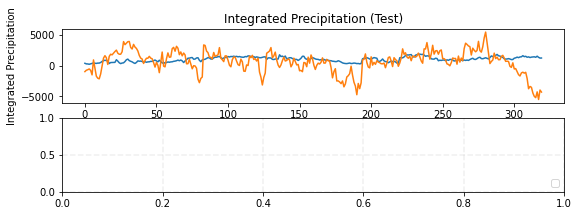

In [25]:
fig,ax = plt.subplots(2,1,figsize=(9,3))
ax[0].plot(y_precip['test'],label='train_truth')
ax[0].plot(wpac_mlr_precip.predict(X_precip['test']),label='train_pred')
ax[0].set_xlabel('Time Samples')
ax[0].set_ylabel('Integrated Precipitation')
plt.legend(loc=4,ncol=2)
plt.grid(alpha=0.2,lw=1.5,ls='--')
ax[0].set_title('Integrated Precipitation (Test)')
#plt.savefig('/home/saranya/Downloads/plots_output/integratedprecip_valid.png',dpi=400,facecolor='w')
plt.show()

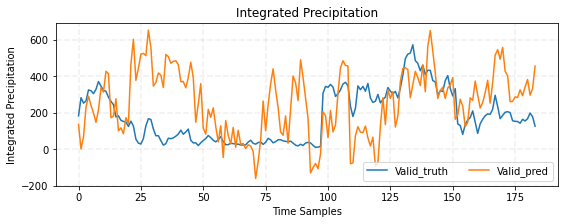

In [194]:
fig,ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(y_nonan['valid'],label='Valid_truth')
ax.plot(wpac_mlr.predict(X_nonan['valid']),label='Valid_pred')
plt.legend(loc=4,ncol=2)
plt.grid(alpha=0.2,lw=1.5,ls='--')
plt.title('Integrated Precipitation')
plt.xlabel('Time Samples')
plt.ylabel('Integrated Precipitation')
plt.savefig('/home/saranya/Downloads/plots_output/integratedprecip_valid.png',dpi=400,facecolor='w')
plt.show()

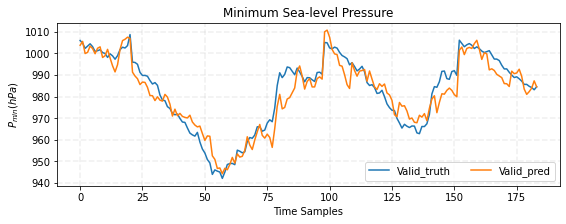

In [196]:
fig,ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(y_pmin['valid'],label='Valid_truth')
ax.plot(wpac_mlr_pmin.predict(X_pmin['valid']),label='Valid_pred')
plt.legend(loc=4,ncol=2)
plt.grid(alpha=0.2,lw=1.5,ls='--')
plt.title('Minimum Sea-level Pressure')
plt.xlabel('Time Samples')
plt.ylabel('${P_{min}} (hPa)$')
plt.savefig('/home/saranya/Downloads/plots_output/pmin_valid.png',dpi=400,facecolor='w')
plt.show()

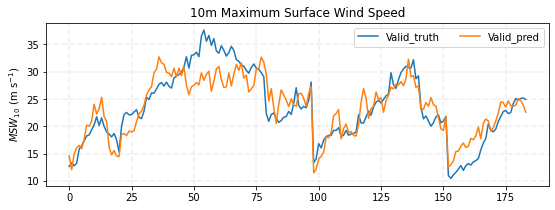

In [197]:
fig,ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(y_v10['valid'],label='Valid_truth')
ax.plot(wpac_mlr_v10.predict(X_v10['valid']),label='Valid_pred')
plt.legend(loc=1,ncol=2)
plt.grid(alpha=0.2,lw=1.5,ls='--')
plt.title('10m Maximum Surface Wind Speed')
plt.ylabel('${MSW_{10}}$ (m s$^{-1}$)')
plt.savefig('/home/saranya/Downloads/plots_output/v10_valid.png',dpi=400,facecolor='w')
plt.show()

North Indian Ocean Storms

In [44]:
from numpy.random import default_rng

rng = default_rng(12345)
seed = rng.choice(48, 10, replace=False)

In [50]:
'cyclone'+str(int(seed[9]))

'cyclone46'

In [46]:
seed

array([13, 35, 18, 28, 27,  9, 31,  8, 32, 46])

In [52]:
data=ddwp.copy()
del data['cyclone'+str(int(seed[0]))]
del data['cyclone'+str(int(seed[1]))]
del data['cyclone'+str(int(seed[2]))]
del data['cyclone'+str(int(seed[3]))]
del data['cyclone'+str(int(seed[4]))]
del data['cyclone'+str(int(seed[5]))]
del data['cyclone'+str(int(seed[6]))]
del data['cyclone'+str(int(seed[7]))]
del data['cyclone'+str(int(seed[8]))]
del data['cyclone'+str(int(seed[9]))]

Extract Variable and lag information

In [59]:
filtvar_lag_dict = {'precip':[obj for obj in arr[0]],\
                    'pmin':[obj for obj in arr[1]],\
                   '10wspd':[obj for obj in arr[2]]}

In [60]:
data['cyclone1'][:(filtvar_lag_dict['precip'][0][1]),156]

array([0.01602166, 0.01646996, 0.0206255 , 0.03346259, 0.04662046,
       0.04634654, 0.02408053, 0.01397228, 0.01491111, 0.02407614,
       0.02368177, 0.03442036, 0.04766599, 0.05906334, 0.08540045,
       0.10599098, 0.12543761, 0.12139301, 0.0737608 , 0.05125052,
       0.02542992, 0.01840909, 0.01610788, 0.01974525, 0.01987464,
       0.01850446, 0.01682129, 0.01493174, 0.01982585, 0.03260581,
       0.02519143, 0.01372967, 0.0116464 , 0.00692698, 0.00378462,
       0.00426407, 0.00904172, 0.00973447, 0.00680046, 0.00681906,
       0.00810528, 0.00646979, 0.00342528, 0.00338809, 0.00384294,
       0.00384591, 0.00236219, 0.00482553, 0.0047624 , 0.00668557,
       0.00624483, 0.00614478, 0.00763378, 0.00917241, 0.0054863 ,
       0.01379989, 0.01314596, 0.01095225, 0.00629012, 0.00626698,
       0.00444031, 0.00707525, 0.0065731 , 0.00863654, 0.0131279 ,
       0.0132541 , 0.01338469, 0.01703943, 0.01457512, 0.02155724,
       0.02453073, 0.03395418, 0.02701791, 0.01891848, 0.02548

In [61]:
# Extract lag info
def extract_lag_info(datar=None,varindex=None,lag=None):
    temp = datar[:,varindex] # Full time series
    store = []
    for timeindex in range(len(temp)):
        if timeindex < np.abs(lag):
            store.append(np.nan)
        elif timeindex > len(temp)-1-np.abs(lag):
            store.append(np.nan)
        else:
            store.append(temp[timeindex-np.abs(lag)])
    return store

In [89]:
varindexstore,lagstore,TS_store,flatTS_store = [],[],[],[]
for varindex,lag in arr[0]:
    varindexstore.append(varindex)
    lagstore.append(lag)
    tempp = [extract_lag_info(datar=ddwp[obj],varindex=varindex,lag=lag) for obj in ddwp.keys()]
    TS_store.append(tempp)
    flatTS_store.append(np.concatenate([obj for obj in tempp]))

In [91]:
TSnorml_store = []
for i in range(len(TS_store)):
    tempmean,tempstd = np.nanmean(flatTS_store[i]),np.nanstd(flatTS_store[i])
    TSnorml_store.append([(obj-tempmean)/tempstd for obj in TS_store[i]])

In [94]:
remove_indices = [13,15]
X_withnan_store, Xtest_withnan_store = [],[]
for i in range(len(TS_store)):
    somelist = [i for j, i in enumerate(TSnorml_store[i]) if j not in remove_indices]
    testlist = [i for j, i in enumerate(TSnorml_store[i]) if j in remove_indices]
    X_withnan_store.append(np.concatenate([obj for obj in somelist]))
    Xtest_withnan_store.append(np.concatenate([obj for obj in testlist]))

In [65]:
#X_withnan_store = []
#for varindex in range(len(TS_store)):
#    tempp = np.concatenate([(obj-np.nanmean(obj))/np.nanstd(obj) for obj in TS_store[varindex]])
#    X_withnan_store.append((tempp-np.nanmean(tempp))/np.nanstd(tempp))

In [110]:
Yall = [ddwp[obj][:,0] for obj in ddwp.keys()]
Ytrain,Ytest = np.concatenate([i for j, i in enumerate(Yall) if j not in remove_indices]),\
np.concatenate([i for j, i in enumerate(Yall) if j in remove_indices])

In [111]:
len(Ytest)

136

In [112]:
X_nonan,Y_nonan = [],[]
X_withnan_storer = np.asarray(X_withnan_store).transpose()
for i in (range(len(Ytrain))):
    tempX = X_withnan_storer[i,:]
    if np.isnan(tempX).any():
        continue
    else:
        X_nonan.append(tempX)
        Y_nonan.append(Ytrain[i])

In [113]:
#TStest_store = []
#for varindex,lag in arr[0]:
#    TStest_store.append(extract_lag_info(datar=ddwp['cyclone13'],varindex=varindex,lag=lag))

#Xtest_withnan_store = []
#for varindex in range(len(TStest_store)):
#    Xtest_withnan_store.append((TStest_store[varindex]-np.nanmean(TStest_store[varindex]))/np.nanstd(TStest_store[varindex]))
X_nonan,Y_nonan = [],[]
X_withnan_storer = np.asarray(X_withnan_store).transpose()
for i in (range(len(Ytrain))):
    tempX = X_withnan_storer[i,:]
    if np.isnan(tempX).any():
        continue
    else:
        X_nonan.append(tempX)
        Y_nonan.append(Ytrain[i])
        

Xtest_nonan,ytest_nonan = [],[]
Xtest_withnan_storer = np.asarray(Xtest_withnan_store).transpose()
for i in (range(len(Ytest))):
    tempX = Xtest_withnan_storer[i,:]
    if np.isnan(tempX).any():
        continue
    else:
        Xtest_nonan.append(tempX)
        ytest_nonan.append(Ytest[i])

In [114]:
np.asarray(Xtest_nonan).shape, np.asarray(X_nonan).shape

((72, 1594), (1805, 1594))

In [115]:
regr = LinearRegression()
regr.fit(X_nonan,Y_nonan)

LinearRegression()

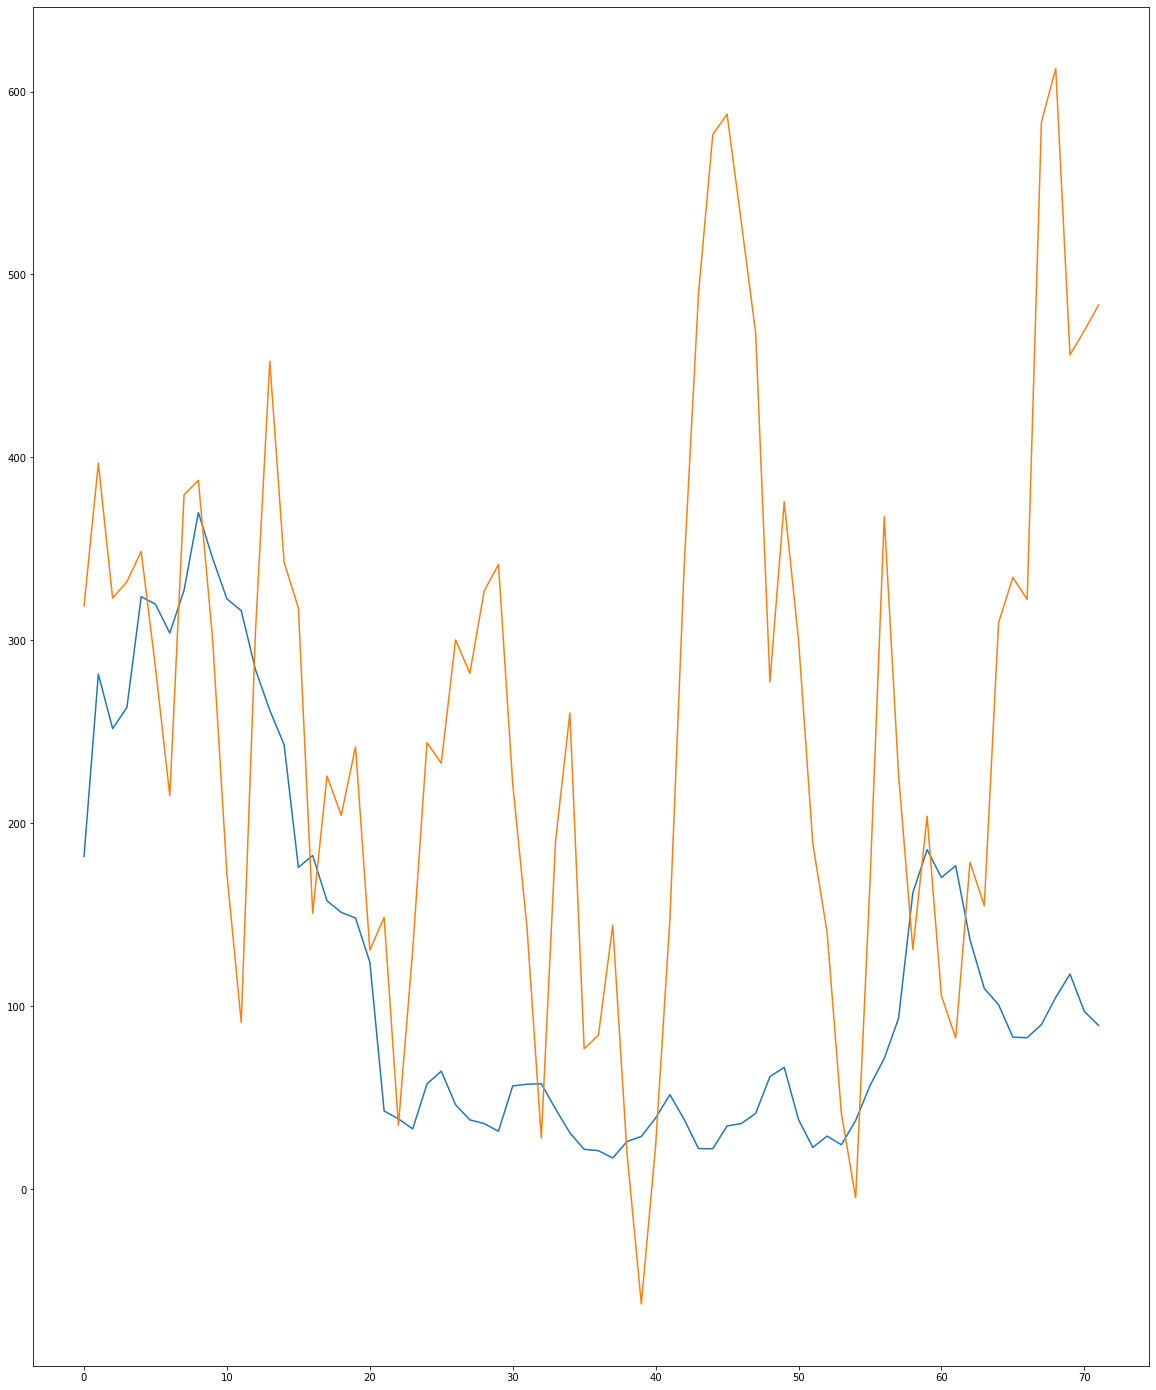

In [117]:
plt.plot(ytest_nonan)
plt.plot(regr.predict(Xtest_nonan))
plt.show()

Pipeline for entire timeseries

In [ ]:
class Pipeline:
    """
    Linear Regression Pipeline
    """
    def __init__(self,data,pc_alpha,pc_type='run_pcstable' or 'pcmci',pcmci_results=None,target='precip',seed=None):
        self.pc_alpha = pc_alpha
        self.data = data
        self.pc_type = pc_type
        self.target = target
        self.pcmci_results = pcmci_results
        
    def flatten_array(self,index=None,normalize=True):
        """
        Get concatenated time series
        index: variable index to extract
        """
        if normalize is True:
            temp = np.concatenate([self.data[obj][:,int(self.pcmci_results[self.target][index])] 
                                   for obj in self.data.keys()])
            return (temp-np.nanmean(temp))/np.nanstd(temp)
        else:
            return np.concatenate([self.data[obj][:,int(self.pcmci_results[self.target][index])] 
                                   for obj in self.data.keys()])
    
    def get_INPUTtimeseries(self):
        storeresults = []
        for ind,obj in enumerate(range(len(self.pcmci_results[self.target]))):
            storeresults.append(self.flatten_array(obj,True))
        return np.transpose(np.asarray(storeresults))
    
    def get_OUTPUTtimeseries(self):
        if self.target=='precip':
            return np.concatenate([self.data[obj][:,0] for obj in self.data.keys()])
        elif self.target=='pmin':
            return np.concatenate([self.data[obj][:,1] for obj in self.data.keys()])
        elif self.target=='10wspd':
            return np.concatenate([self.data[obj][:,2] for obj in self.data.keys()])
    
    def fit_transform(self,Xdata=None):
        storeresults = []
        for ind,obj in enumerate(range(len(self.pcmci_results[self.target]))):
            temp = Xdata[:,int(self.pcmci_results[self.target][obj])]
            tempn = (temp-np.nanmean(temp))/np.nanstd(temp)
            storeresults.append(tempn)
        return np.transpose(np.asarray(storeresults))
        
    def fit_model(self,X=None,y=None):
        regr = LinearRegression()
        return regr.fit(X,y)

In [ ]:
Xtest = Pipeline(data,0.05,'pcmci',filtvarindex,'precip').fit_transform(ddwp['cyclone13'])

In [ ]:
Xtrain = Pipeline(data,0.05,'pcmci',filtvarindex,'precip').get_INPUTtimeseries()
ytrain = Pipeline(data,0.05,'pcmci',filtvarindex,'precip').get_OUTPUTtimeseries()

In [ ]:
linrgr_model1 = Pipeline(data,0.05,'pcmci',filtvarindex,'precip').fit_model(Xtrain,ytrain)

In [ ]:
plt.plot(ddwp['cyclone13'][:,0])
plt.plot(linrgr_model1.predict(Xtest))
plt.show()

In [ ]:
linrgr_model1.predict(Xtest)